In [1]:
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix, log_loss, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from model_header import DfExtractor, ModelHousing

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
# Set variable names up as per data_harvest

demographics = ['age','sex']

illnesses= ['alzheimers','heart_failure','kidney_disease','cancer',
                'pulmonary_disease','depression','diabetes','ischemic_heart_disease',
                'osteoporosis','arthritis','stroke']

cover_info = ['in_cover_dur','out_cover_dur','carrier_cover_dur','drug_cover_dur',
             'in_cover_amt','out_cover_amt','in_excess_amt','out_excess_amt']

basic_features = demographics + illnesses + cover_info

In [3]:
# we have a fair few targets here

#will the customer claim, how many times and total amount
status_target = ['claimed']
amount_target = ['total_claimed']
claimnum_target = ['no_of_claims']

# outpatient specific
outpat_amount_target = ['outpat_total_claimed']
outpat_claimnum_target = ['outpat_no_of_claims']

#inpatient specific
inpat_amount_target = ['inpat_total_claimed']
inpat_claimnum_target = ['inpat_no_of_claims']


In [4]:
all_feats = basic_features + status_target + amount_target + claimnum_target
all_feats = all_feats + outpat_amount_target + outpat_claimnum_target
all_feats = all_feats + inpat_amount_target + inpat_claimnum_target

In [5]:
state_num = 4211

In [6]:
cwd = os.getcwd() + '/'
models_path = cwd + 'models/'

if not os.path.exists(models_path):
    os.mkdir(models_path)

In [7]:
def read_data():
    df = pd.read_csv('data/gcm/gcm_data.csv',usecols=all_feats)
#     df = df[:100000]
    return df

In [8]:
class ModelTrainer():
    def __init__(self, params, cv_params):
        self.model_pipe = None
        
        # modes, features to be computed
        # encoded cols, imputed cols, and target as param dict
        self.mode = params.get('mode')
        self.features = params.get('features')
        self.ohe_feats = params.get('ohe_feats')
        self.imp_feats = params.get('imp_feats')
        self.y_target = params.get('y_target')
        
        self.cv_params = cv_params
        
    def split_data(self, df, y_target):
        X = df.drop(y_target, axis=1)[self.features]
        y = df[y_target]
        
        test_ratio = 0.2
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_ratio, 
                                                            random_state=state_num)
        
        return X_train, y_train, X_test, y_test

    
    def build_pipeline(self):
        skf = StratifiedKFold(n_splits=3)
        
        if self.mode == 'class':
            grid_model = lgb.LGBMClassifier()
        elif self.mode == 'regr':
            grid_model = lgb.LGBMRegressor()
        else:
            raise ValueError('Specify mode as either """class""" or """regr""".')
            
        
        grid_search = GridSearchCV(estimator=grid_model, param_grid=self.cv_params, 
                                   cv=skf, refit=True, verbose=3)

        ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
        imp = IterativeImputer()
        
        df_extractor = DfExtractor()
        
        column_transformer = ColumnTransformer(transformers=[
            ('ohe', ohe, self.ohe_feats),
            ('imp', imp, self.imp_feats)
        ],remainder='passthrough').set_output(transform="pandas")

        
        model_pipe = Pipeline(steps=[
            ('column_transformer', column_transformer),
            ('df_extractor', df_extractor),
            ('grid_search', grid_search)
        ])

        return model_pipe
        
    def evaluate_model_class(self, y_test, y_pred, y_pred_prob, silent):
        print(classification_report(y_test,y_pred))
        print('log loss:')
        print(log_loss(y_test, y_pred_prob))
        
        if silent == False:
            cm = confusion_matrix(y_test, y_pred)
            cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fig, ax = plt.subplots(figsize=(6,6))

            sns.heatmap(cmn, annot=True, fmt='.2f',cmap='flare')
            plt.ylabel('actual')
            plt.xlabel('predicted')
            plt.show(block=False)
        
    def evaluate_model_regr(self, y_test, y_pred, silent):
        # visualizing in a plot
        if silent == False:
            x_ax = range(len(y_test))
            plt.figure(figsize=(12, 6))
            plt.plot(x_ax, y_test, label="original")
            plt.plot(x_ax, y_pred, label="predicted")
            plt.title("test and predicted data")
            plt.xlabel('X (records)')
            plt.ylabel('y (pred value)')
            plt.legend(loc='best',fancybox=True, shadow=True)
            plt.grid(True)
            plt.show(block=False)  
        
        # accuracy check
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**(0.5)
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse) 

    def construct_model(self,df,silent=False):
        X_train, y_train, X_test, y_test = self.split_data(df, self.y_target)
        model_pipe = self.build_pipeline()
        model_pipe.fit(X_train, np.ravel(y_train))
        
        y_pred = model_pipe.predict(X_test)
        
        if self.mode == 'class':
            y_pred_prob = model_pipe.predict_proba(X_test)
            self.evaluate_model_class(y_test, y_pred, y_pred_prob, silent)
        elif self.mode == 'regr':
            self.evaluate_model_regr(y_test, y_pred, silent)
            
        
        self.model_pipe = model_pipe
    
    # couldnt think of another name, it houses the pipeline and lets me do SHAPs easy at app level
    def get_model_housing(self, dump_to=None, mode=None):
        model_pipe = self.model_pipe
        
        #wipe the last df extracted for shap value analysis
        model_pipe.named_steps['df_extractor'].data_frame = None
        
        mh = ModelHousing(self.model_pipe, self.mode)
        if dump_to != None:
            file = open(models_path + dump_to, 'wb')
            pickle.dump(mh, file)
            file.close()
            
        return mh
        

In [9]:
ohe_feats = ['sex'] + illnesses
imp_feats = [feat for feat in basic_features if feat not in ohe_feats]

In [10]:
df = read_data()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ................learning_rate=0.03;, score=0.903 total time=  10.9s
[CV 2/3] END ................learning_rate=0.03;, score=0.902 total time=  11.5s
[CV 3/3] END ................learning_rate=0.03;, score=0.903 total time=  10.7s
              precision    recall  f1-score   support

           0       0.74      0.92      0.82    329052
           1       0.97      0.90      0.93   1013746

    accuracy                           0.90   1342798
   macro avg       0.86      0.91      0.88   1342798
weighted avg       0.92      0.90      0.91   1342798

log loss:
0.220920094223776


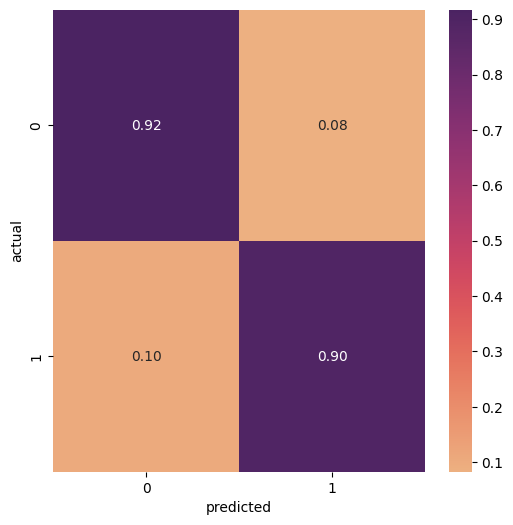

In [11]:
# CLAIM STATUS MODEL

params_status = {
    'mode' : 'class',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : status_target
}

cv_params_status = {
    'learning_rate' : ([0.03])
}

mt_status_class = ModelTrainer(params_status, cv_params_status)
mt_status_class.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 1 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.549 total time=  11.1s
[CV 2/3] END ................learning_rate=0.03;, score=0.547 total time=  10.6s
[CV 3/3] END ................learning_rate=0.03;, score=0.548 total time=  11.1s


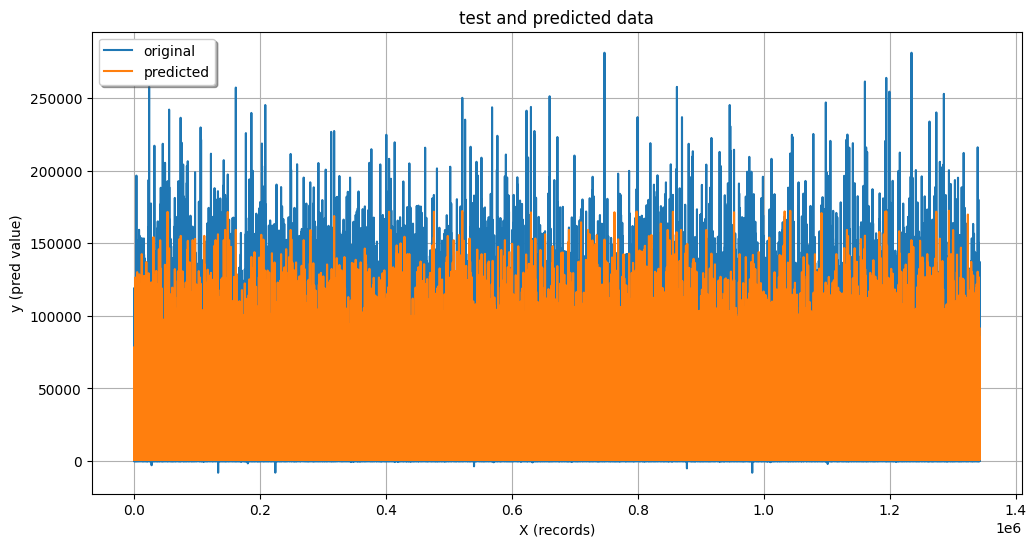

MSE: 106716907.97
RMSE: 10330.39


In [12]:
# CLAIM AMOUNT MODEL

params_amount_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : amount_target
}

cv_params_amount_regr = {
    'learning_rate' : ([0.03])
}

mt_amount_regr = ModelTrainer(params_amount_regr, cv_params_amount_regr)
mt_amount_regr.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 2 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.636 total time=  12.8s
[CV 2/3] END ................learning_rate=0.03;, score=0.635 total time=  12.4s
[CV 3/3] END ................learning_rate=0.03;, score=0.635 total time=  12.4s


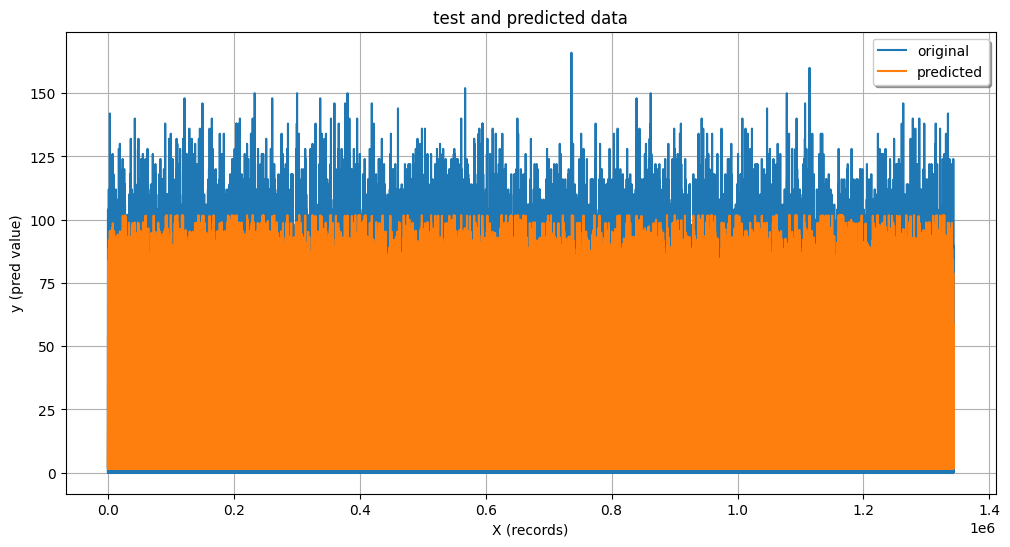

MSE: 110.45
RMSE: 10.51


In [13]:
# CLAIM NUMBER MODEL

params_claimnum_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : claimnum_target
}

cv_params_claimnum_regr = {
    'learning_rate' : ([0.03])
}

mt_claimnum_regr = ModelTrainer(params_claimnum_regr, cv_params_claimnum_regr)
mt_claimnum_regr.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 1 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.758 total time=  10.1s
[CV 2/3] END ................learning_rate=0.03;, score=0.760 total time=   9.5s
[CV 3/3] END ................learning_rate=0.03;, score=0.756 total time=   9.6s


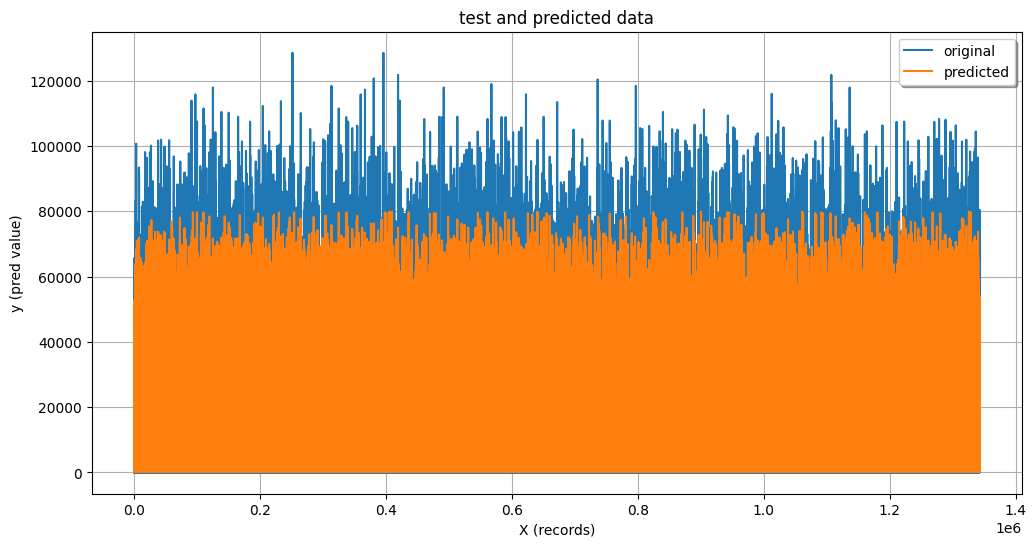

MSE: 6827538.18
RMSE: 2612.96


In [14]:
# OUTPATIENT CLAIM AMOUNT

params_outpat_amount_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : outpat_amount_target
}

cv_params_outpat_amount_regr = {
    'learning_rate' : ([0.03])
}

mt_outpat_amount_regr = ModelTrainer(params_outpat_amount_regr, cv_params_outpat_amount_regr)
mt_outpat_amount_regr.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 2 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.636 total time=  12.3s
[CV 2/3] END ................learning_rate=0.03;, score=0.635 total time=  11.7s
[CV 3/3] END ................learning_rate=0.03;, score=0.635 total time=  11.9s


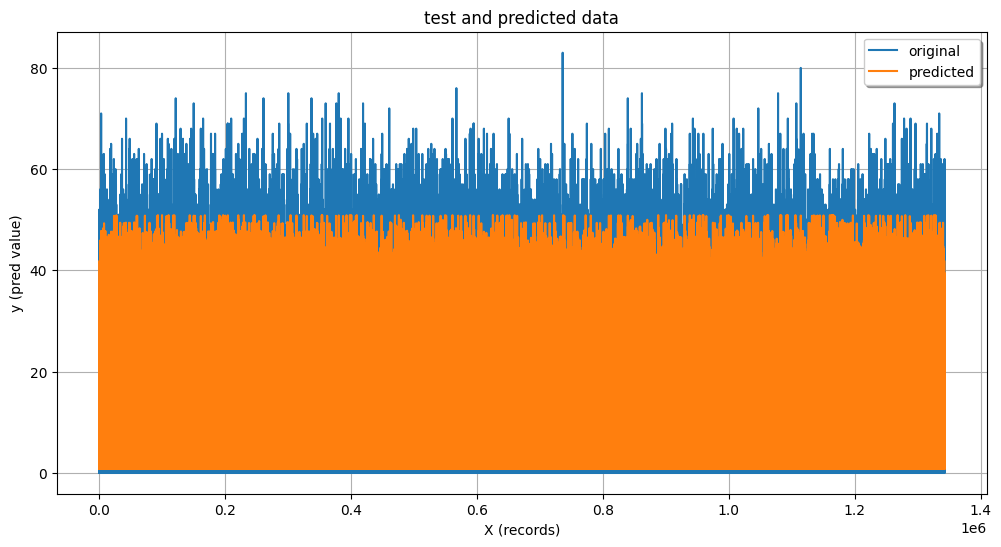

MSE: 27.61
RMSE: 5.25


In [15]:
# OUTPATIENT CLAIM NUMBER

params_outpat_claimnum_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : outpat_claimnum_target
}

cv_params_outpat_claimnum_regr = {
    'learning_rate' : ([0.03])
}

mt_outpat_claimnum_regr = ModelTrainer(params_outpat_claimnum_regr, cv_params_outpat_claimnum_regr)
mt_outpat_claimnum_regr.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 1 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.449 total time=  11.0s
[CV 2/3] END ................learning_rate=0.03;, score=0.448 total time=  11.3s
[CV 3/3] END ................learning_rate=0.03;, score=0.448 total time=  10.7s


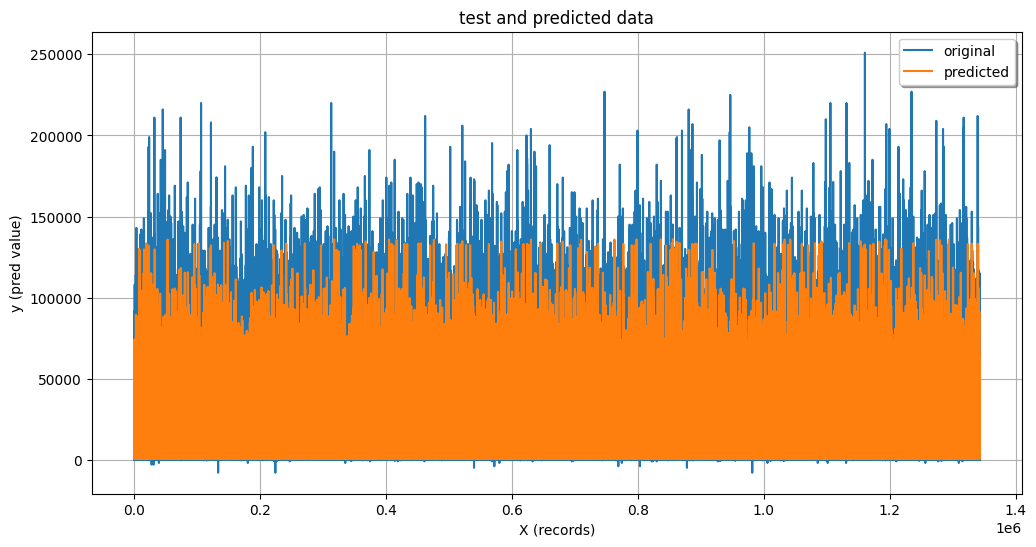

MSE: 93615719.63
RMSE: 9675.52


In [16]:
# INPATIENT CLAIM AMOUNT

params_inpat_amount_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : inpat_amount_target
}

cv_params_inpat_amount_regr = {
    'learning_rate' : ([0.03])
}

mt_inpat_amount_regr = ModelTrainer(params_inpat_amount_regr, cv_params_inpat_amount_regr)
mt_inpat_amount_regr.construct_model(df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


The least populated class in y has only 2 members, which is less than n_splits=3.


[CV 1/3] END ................learning_rate=0.03;, score=0.636 total time=  12.2s
[CV 2/3] END ................learning_rate=0.03;, score=0.635 total time=  12.0s
[CV 3/3] END ................learning_rate=0.03;, score=0.635 total time=  12.0s


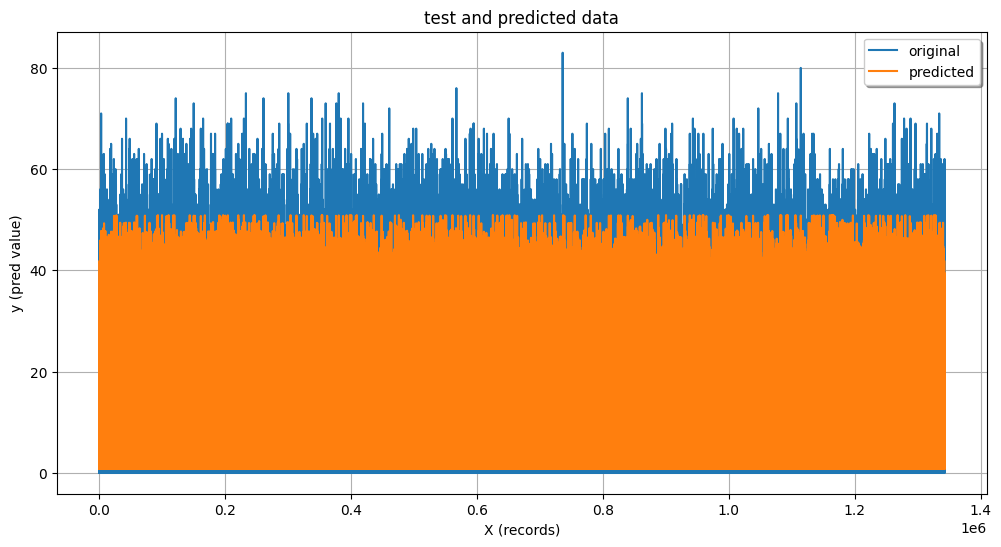

MSE: 27.61
RMSE: 5.25


In [17]:
# INPATIENT CLAIM NUMBER

params_inpat_claimnum_regr = {
    'mode' : 'regr',
    'features' : basic_features,
    'ohe_feats' : ohe_feats,
    'imp_feats' : imp_feats,
    'y_target' : inpat_claimnum_target
}

cv_params_inpat_claimnum_regr = {
    'learning_rate' : ([0.03])
}
mt_inpat_claimnum_regr = ModelTrainer(params_inpat_claimnum_regr, cv_params_inpat_claimnum_regr)
mt_inpat_claimnum_regr.construct_model(df)

In [18]:
mh_status = mt_status_class.get_model_housing(dump_to='status_housing.pkl')
mh_claimnum = mt_claimnum_regr.get_model_housing(dump_to='claimnum_housing.pkl')
mh_amount = mt_amount_regr.get_model_housing(dump_to='amount_housing.pkl')

mh_outpat_amount = mt_outpat_amount_regr.get_model_housing(dump_to='outpat_amount_housing.pkl')
mh_outpat_claimnum = mt_outpat_claimnum_regr.get_model_housing(dump_to='outpat_claimnum_housing.pkl')

mh_inpat_amount = mt_inpat_amount_regr.get_model_housing(dump_to='inpat_amount_housing.pkl')
mh_inpat_claimnum = mt_inpat_claimnum_regr.get_model_housing(dump_to='inpat_claimnum_housing.pkl')


In [19]:
test_df = df.iloc[0:10]
out_dict = mh_status.make_prediction(test_df)
out_dict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


{'row_0': {'y_pred': 1,
  'shap_vals': [('imp__out_cover_amt', 49.57266988789111),
   ('imp__out_excess_amt', 36.65467086008925),
   ('imp__out_cover_dur', 5.505840398455471),
   ('ohe__ischemic_heart_disease_0', -2.721849410563382),
   ('ohe__diabetes_0', -1.159570700277469),
   ('imp__in_excess_amt', -1.0649218705911723),
   ('imp__carrier_cover_dur', -0.9327613414997611),
   ('imp__in_cover_dur', -0.7561602463017901),
   ('imp__drug_cover_dur', 0.4796516761202606),
   ('ohe__heart_failure_0', -0.366934857025881),
   ('ohe__osteoporosis_0', -0.14975014900285863),
   ('ohe__depression_0', -0.13905148684941254),
   ('ohe__arthritis_0', -0.11801081722143583),
   ('imp__age', 0.09896711798686249),
   ('ohe__alzheimers_0', -0.07321897614504878),
   ('ohe__kidney_disease_0', -0.07265472554537428),
   ('ohe__pulmonary_disease_0', -0.059598538289404986),
   ('ohe__cancer_0', -0.054716851711188466),
   ('ohe__stroke_0', -0.010041355113589463),
   ('ohe__sex_0', -0.008958733319275705),
   ('oh

In [20]:
test_df = df.iloc[0:10]
out_dict = mh_amount.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 2480.00827327404,
  'shap_vals': [('imp__in_cover_amt', -31.71559747308774),
   ('imp__out_cover_amt', -11.425921132585033),
   ('ohe__kidney_disease_0', -9.79233682331906),
   ('ohe__heart_failure_0', -8.601050680729683),
   ('ohe__ischemic_heart_disease_0', -5.453012584771682),
   ('imp__out_excess_amt', -4.453873680930715),
   ('imp__age', 3.9535952447036644),
   ('ohe__ischemic_heart_disease_1', -3.807280484908925),
   ('ohe__diabetes_0', -3.6358091416184535),
   ('ohe__heart_failure_1', -3.0463014245825226),
   ('ohe__diabetes_1', -2.5544642297053572),
   ('ohe__pulmonary_disease_0', -2.3569697055076744),
   ('ohe__alzheimers_0', -1.8762214947661493),
   ('ohe__depression_0', -1.5832794189357648),
   ('ohe__kidney_disease_1', -1.0367662506957114),
   ('imp__in_excess_amt', -1.0310862859161738),
   ('imp__out_cover_dur', 0.7245519559534261),
   ('imp__drug_cover_dur', 0.6656464265393018),
   ('ohe__depression_1', -0.5692984186668912),
   ('ohe__arthritis_0', -0

In [21]:
test_df = df.iloc[0:10]
out_dict = mh_claimnum.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 8.905845329065189,
  'shap_vals': [('imp__out_excess_amt', -26.540580117771395),
   ('imp__out_cover_amt', -20.021666000874433),
   ('ohe__heart_failure_0', -8.10811196857642),
   ('ohe__ischemic_heart_disease_0', -6.706134479752812),
   ('ohe__diabetes_0', -6.702626760838036),
   ('ohe__kidney_disease_0', -5.62149960888352),
   ('ohe__depression_0', -4.6632857793204305),
   ('ohe__diabetes_1', -3.6901764390856893),
   ('imp__in_excess_amt', -3.183427940426649),
   ('ohe__ischemic_heart_disease_1', -2.9585449090529825),
   ('ohe__alzheimers_0', -2.4770080623114263),
   ('ohe__pulmonary_disease_0', -1.9598483624974614),
   ('imp__drug_cover_dur', 1.9217033210593462),
   ('imp__out_cover_dur', 1.1754756334300758),
   ('imp__age', 0.8868741090245837),
   ('ohe__heart_failure_1', -0.5801265242857925),
   ('ohe__arthritis_0', -0.5462662806344278),
   ('ohe__osteoporosis_0', -0.4193847575730425),
   ('ohe__pulmonary_disease_1', -0.37980463954745547),
   ('ohe__cancer_0',

In [22]:
test_df = df.iloc[0:10]
out_dict = mh_outpat_amount.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 616.5694685838562,
  'shap_vals': [('imp__out_cover_amt', -65.96884869191943),
   ('imp__out_excess_amt', -9.776355276379185),
   ('ohe__kidney_disease_0', -7.273259845060942),
   ('ohe__heart_failure_0', -2.8110729842729345),
   ('ohe__ischemic_heart_disease_0', -2.648005520396862),
   ('ohe__diabetes_0', -2.4592860899735367),
   ('ohe__diabetes_1', -1.7494553704335076),
   ('ohe__ischemic_heart_disease_1', -1.552387998473993),
   ('ohe__depression_0', -1.343849109639383),
   ('imp__out_cover_dur', 0.7206504678002865),
   ('imp__drug_cover_dur', 0.6531895589206559),
   ('ohe__kidney_disease_1', -0.6377786586341949),
   ('imp__in_excess_amt', -0.6314638331383033),
   ('ohe__alzheimers_0', -0.398861528088778),
   ('ohe__cancer_1', -0.2930528040043672),
   ('ohe__cancer_0', -0.28167299989855),
   ('ohe__depression_1', -0.25764884168090685),
   ('ohe__pulmonary_disease_1', -0.12870126484302855),
   ('ohe__heart_failure_1', -0.10276230999251672),
   ('ohe__arthritis_0'

In [23]:
test_df = df.iloc[0:10]
out_dict = mh_outpat_claimnum.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 4.452922664532594,
  'shap_vals': [('imp__out_excess_amt', -26.540580117771395),
   ('imp__out_cover_amt', -20.021666000874433),
   ('ohe__heart_failure_0', -8.10811196857642),
   ('ohe__ischemic_heart_disease_0', -6.706134479752812),
   ('ohe__diabetes_0', -6.702626760838036),
   ('ohe__kidney_disease_0', -5.62149960888352),
   ('ohe__depression_0', -4.6632857793204305),
   ('ohe__diabetes_1', -3.6901764390856893),
   ('imp__in_excess_amt', -3.183427940426649),
   ('ohe__ischemic_heart_disease_1', -2.9585449090529825),
   ('ohe__alzheimers_0', -2.4770080623114263),
   ('ohe__pulmonary_disease_0', -1.9598483624974614),
   ('imp__drug_cover_dur', 1.9217033210593462),
   ('imp__out_cover_dur', 1.1754756334300758),
   ('imp__age', 0.8868741090245837),
   ('ohe__heart_failure_1', -0.5801265242857925),
   ('ohe__arthritis_0', -0.5462662806344278),
   ('ohe__osteoporosis_0', -0.4193847575730425),
   ('ohe__pulmonary_disease_1', -0.37980463954745547),
   ('ohe__cancer_0',

In [24]:
test_df = df.iloc[0:10]
out_dict = mh_inpat_amount.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 2025.3216501390566,
  'shap_vals': [('imp__in_cover_amt', -40.63394062414663),
   ('ohe__heart_failure_0', -10.715832323883342),
   ('ohe__kidney_disease_0', -7.697285170995591),
   ('ohe__ischemic_heart_disease_0', -5.500720769396662),
   ('imp__age', 5.160452809882449),
   ('imp__out_cover_amt', 4.543368188619986),
   ('ohe__ischemic_heart_disease_1', -3.8915122745686883),
   ('ohe__diabetes_0', -3.4937225706102693),
   ('ohe__pulmonary_disease_0', -3.1835085661706612),
   ('ohe__diabetes_1', -2.510104305126238),
   ('ohe__alzheimers_0', -2.0902623515493812),
   ('ohe__heart_failure_1', -1.9538375068526177),
   ('ohe__depression_0', -1.7383236708088685),
   ('imp__out_excess_amt', -1.6909277329944516),
   ('ohe__kidney_disease_1', -1.511143684560677),
   ('imp__out_cover_dur', 0.6323269974432232),
   ('imp__drug_cover_dur', 0.5657964984207181),
   ('ohe__depression_1', -0.5249601411241906),
   ('ohe__stroke_0', -0.46436213092674455),
   ('ohe__alzheimers_1', -0.4

In [25]:
test_df = df.iloc[0:10]
out_dict = mh_inpat_claimnum.make_prediction(test_df)
out_dict

{'row_0': {'y_pred': 4.452922664532594,
  'shap_vals': [('imp__out_excess_amt', -26.540580117771395),
   ('imp__out_cover_amt', -20.021666000874433),
   ('ohe__heart_failure_0', -8.10811196857642),
   ('ohe__ischemic_heart_disease_0', -6.706134479752812),
   ('ohe__diabetes_0', -6.702626760838036),
   ('ohe__kidney_disease_0', -5.62149960888352),
   ('ohe__depression_0', -4.6632857793204305),
   ('ohe__diabetes_1', -3.6901764390856893),
   ('imp__in_excess_amt', -3.183427940426649),
   ('ohe__ischemic_heart_disease_1', -2.9585449090529825),
   ('ohe__alzheimers_0', -2.4770080623114263),
   ('ohe__pulmonary_disease_0', -1.9598483624974614),
   ('imp__drug_cover_dur', 1.9217033210593462),
   ('imp__out_cover_dur', 1.1754756334300758),
   ('imp__age', 0.8868741090245837),
   ('ohe__heart_failure_1', -0.5801265242857925),
   ('ohe__arthritis_0', -0.5462662806344278),
   ('ohe__osteoporosis_0', -0.4193847575730425),
   ('ohe__pulmonary_disease_1', -0.37980463954745547),
   ('ohe__cancer_0',